### Import libraries

In [26]:
import pandas as pd
import numpy as np
import datetime
from itertools import cycle
import geopandas as gpd
from shapely.geometry import Point
import random
import matplotlib.pyplot as plt

### Load Geodata

In [28]:
# load geodata
india = gpd.read_file("INDIAN-SHAPEFILES-master/INDIA_DISTRICTS.geojson")
print(india.head())

            dtname   stname stcode11 dtcode11   year_stat   SHAPE_Length  \
0            Morbi  GUJARAT       24      727  update2014  598334.202641   
1        Ahmadabad  GUJARAT       24      474      2011_c  950616.802956   
2            Anand  GUJARAT       24      482      2011_c  434665.001203   
3  Devbhumi Dwarka  GUJARAT       24      728  update2014  730297.608335   
4         Jamnagar  GUJARAT       24      477      2011_c  814332.844603   

     SHAPE_Area  OBJECTID  test  Dist_LGD  State_LGD  \
0  5.892260e+09         1   NaN       673         24   
1  8.557033e+09         2   NaN       438         24   
2  3.732902e+09         3   NaN       440         24   
3  4.869684e+09         4   NaN       674         24   
4  6.944454e+09         5   NaN       447         24   

                                            geometry  
0  POLYGON ((71.27029 23.15576, 71.26874 23.15591...  
1  POLYGON ((72.33651 23.10707, 72.33487 23.10812...  
2  POLYGON ((73.21971 22.62603, 73.21961 

### Set constants

In [53]:
# list of skills
skills = ['vaccination', 'pathology', 'art_test']

# prices of services
service_pricing_dict = {
    'vaccination': 100,
    'pathology': 200,
    'art_test': 50,
}

# time taken to carry out each service
service_duration_dict = {
    'vaccination': 0.5,
    'pathology': 1,
    'art_test': 0.4,
}

# generate orders between start and end date
start_date, end_date = '2023-02-12','2023-02-12'

# size of dataframe
size = 100

# seed
seed = random.randint(0, 9999)

### Functions

In [54]:
def generate_coords(size=size, seed=seed, district=None):
    
    # seed cannot be none to ensure same district is generated for both datasets
    rng = np.random.default_rng(seed) 

    # if district is none, randomly choose some district using seed
    if district == None:
        district = rng.choice(india['dtname'].unique(), 1)[0]

    print(f"District selected: {district}")
    data = india[india['dtname'] == district]
    
    # bounds of geodata
    x_min, y_min, x_max, y_max = data.total_bounds
    points_x = []
    points_y = []
    points = []
    i=0
    while i < size:
        # generate random data within the bounds
        point = Point(random.uniform(x_min, x_max), random.uniform(y_min, y_max))
        if data.contains(point).any():
            points_x.append(point.x)
            points_y.append(point.y)
            points.append(point)
            i += 1
            
    data.plot()
    return points_x, points_y

In [55]:
def create_phleb_df(size=size, seed=seed):
    # random generator 
    rng = np.random.default_rng(seed) 

    df = pd.DataFrame()
    # start shift either at 6 or 7
    df['shift_start_hour'] = rng.integers(6, 8, size)
    df['shift_start'] = rng.choice(pd.date_range(start_date, end_date), size)
    df['shift_start'] += pd.to_timedelta(df.shift_start_hour, unit='h')

    # start break 4 hours after of work
    df['break_start'] = df['shift_start'] + pd.to_timedelta(4, unit='h')

    # shift ends after 8 hours 
    df['shift_end'] = df['shift_start'] + pd.to_timedelta(8, unit='h')

    # random number of skills
    df['num_skills'] =  rng.integers(1, len(skills)+1, size) # each phleb must have at least 1 skill
    # randomly choose skills from list of skills based
    df['skillset'] = df.num_skills.apply(lambda x: str(rng.choice(skills, x, replace=False, shuffle=True))[1:-1]).str.replace("'",'')
    # one-hot encoded columns
    dummies = df['skillset'].str.get_dummies(sep=" ")
    # join df with one-hot encoded columns
    df = pd.concat([df, dummies], axis=1)

    # coordinates of phlebo's home
    home = generate_coords()
    df['home_lat'] = home[0]
    df['home_long'] = home[1]
    
    # coordinates of catchment area
    catchment = generate_coords()
    df['catchment_lat'] = catchment[0]
    df['catchment_long'] = catchment[1]

    print(df)
    df.to_csv(f"Data/phleb_data_{seed}.csv", index=False)
    return df

In [56]:
def create_orders_df(size=size, seed=seed):
    # random generator 
    rng = np.random.default_rng(seed) 

    df = pd.DataFrame()
    # orders can start from 6am to 2pm
    df['order_start_hour'] = rng.integers(6, 15, size)
    df['order_start'] = rng.choice(pd.date_range(start_date, end_date), size)
    df['order_start'] += pd.to_timedelta(df.order_start_hour, unit='h')

    # number of services chosen
    df['num_services'] =  rng.integers(1, len(skills)+1, size) # each order must have at least 1 skill
    # randomly choose skills from list of skills based
    df['services'] = df.num_services.apply(lambda x: str(rng.choice(skills, x, replace=False, shuffle=True))[1:-1]).str.replace("'",'') 
    # one-hot encoded columns
    dummies = df['services'].str.get_dummies(sep=" ")
    # join df with one-hot encoded columns
    df = pd.concat([df, dummies], axis=1)

    # initialise order duration and price columns
    df['duration'] = 0
    df['price'] = 0
    for skill in skills:
        # order duration
        df['duration'] += service_duration_dict.get(skill) * df[skill]
        # order price
        df['price'] += service_pricing_dict[skill] * df[skill]

    df['order_end'] = df['order_start'] + pd.to_timedelta(df['duration'], unit='h')

    # coordinates
    df['lat'] = generate_coords()[0]
    df['long'] = generate_coords()[1]

    print(df)
    df.to_csv(f"Data/order_data_{seed}.csv", index=False)
    return df

### Generate csv

Seed: 4379
District selected: Chota Udaipur
District selected: Chota Udaipur
    shift_start_hour         shift_start         break_start  \
0                  6 2023-02-12 06:00:00 2023-02-12 10:00:00   
1                  6 2023-02-12 06:00:00 2023-02-12 10:00:00   
2                  6 2023-02-12 06:00:00 2023-02-12 10:00:00   
3                  7 2023-02-12 07:00:00 2023-02-12 11:00:00   
4                  6 2023-02-12 06:00:00 2023-02-12 10:00:00   
..               ...                 ...                 ...   
95                 6 2023-02-12 06:00:00 2023-02-12 10:00:00   
96                 6 2023-02-12 06:00:00 2023-02-12 10:00:00   
97                 7 2023-02-12 07:00:00 2023-02-12 11:00:00   
98                 6 2023-02-12 06:00:00 2023-02-12 10:00:00   
99                 6 2023-02-12 06:00:00 2023-02-12 10:00:00   

             shift_end  num_skills                        skillset  art_test  \
0  2023-02-12 14:00:00           1                       pathology        

,order_start_hour,order_start,num_services,services,art_test,pathology,vaccination,duration,price,order_end,lat,long
0,7,2023-02-12 07:00:00,1,pathology,0,1,0,1.0,200,2023-02-12 08:00:00,73.883485,22.187261
1,8,2023-02-12 08:00:00,3,art_test pathology vaccination,1,1,1,1.9,350,2023-02-12 09:54:00,73.912831,22.193928
2,9,2023-02-12 09:00:00,3,vaccination pathology art_test,1,1,1,1.9,350,2023-02-12 10:54:00,73.910590,22.000718
3,12,2023-02-12 12:00:00,3,art_test pathology vaccination,1,1,1,1.9,350,2023-02-12 13:54:00,73.908093,22.376549
4,10,2023-02-12 10:00:00,3,pathology art_test vaccination,1,1,1,1.9,350,2023-02-12 11:54:00,73.883240,22.116912
...,...,...,...,...,...,...,...,...,...,...,...,...
95,7,2023-02-12 07:00:00,2,vaccination pathology,0,1,1,1.5,300,2023-02-12 08:30:00,73.839597,22.259929
96,9,2023-02-12 09:00:00,2,art_test vaccination,1,0,1,0.9,150,2023-02-12 09:54:00,73.805117,22.376828
97,10,2023-02-12 10:00:00,3,art_test vaccination pathology,1,1,1,1.9,350,2023-02-12 11:54:00,73.872923,22.514958
98,9,2023-02-12 09:00:00,1,art_test,1,0,0,0.4,50,2023-02-12 09:24:00,73.967911,22.040263


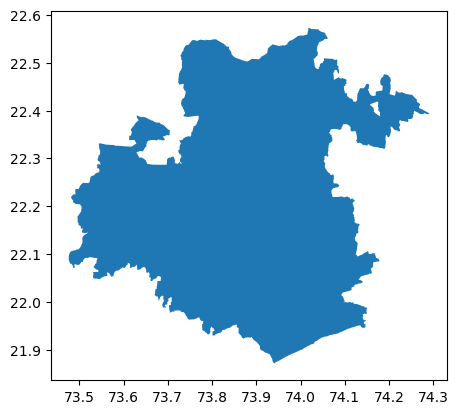

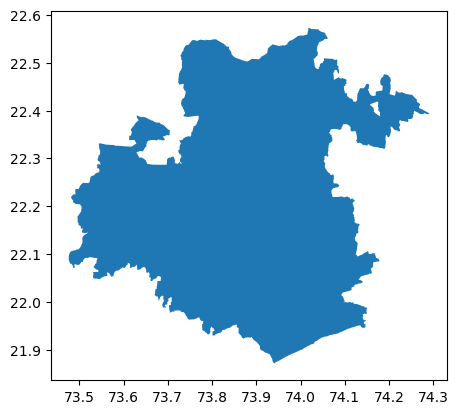

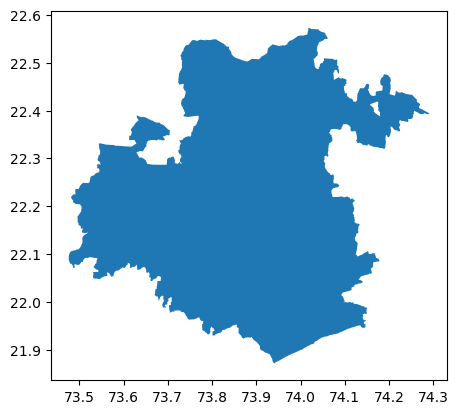

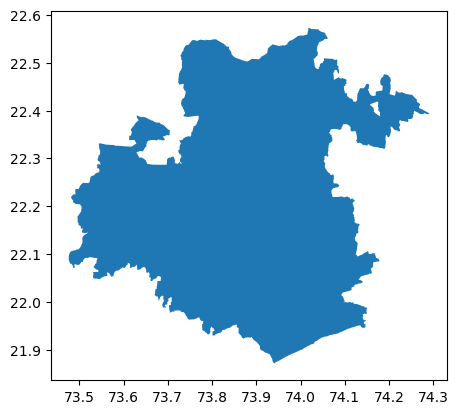

In [58]:
# run functions
print(f"Seed: {seed}")
create_phleb_df()
create_orders_df()